In [53]:
import json
import os

SPLIT = '/home/gemelli/projects/doc2graph/DATA/NAF/simple_train_valid_test_split.json'
DATA = '/home/gemelli/projects/doc2graph/DATA/NAF/groups'

### LOAD SPLIT JSON

In [54]:
with open(SPLIT, 'r') as f:
    split = json.load(f)
train =split['train']
val = split['valid']
test = split['test']

In [55]:
print("Test split json structure:")
for group, docs in train.items():
    if group == '123': continue
    # if group == '155': continue
    print('Group\n  -',group)
    print('Docs')
    for doc in docs:
        print('  -',doc)
    break

Test split json structure:
Group
  - 155
Docs
  - 004173988_00022.jpg


### LOAD AN EXAMPLE IMAGE

In [56]:
realtive_path = os.path.join(group, doc)
full_path = os.path.join(DATA, realtive_path)
full_path

'/home/gemelli/projects/doc2graph/DATA/NAF/groups/155/004173988_00022.jpg'

In [57]:
from PIL import Image

img = Image.open(full_path).convert('RGB')
# img

In [58]:
pre, _ = os.path.splitext(full_path)
annotations = pre + '.json'
with open(annotations, 'r') as f:
    anns = json.load(f)
print(anns.keys())

dict_keys(['fieldBBs', 'actualPage_corners', 'height', 'labelTime', 'page_corners', 'groups', 'horzLinks', 'pairs', 'samePairs', 'checkedBy', 'width', 'textBBs', 'imageFilename', 'transcriptions'])


In [59]:
bboxs = dict()
for key in ['fieldBBs', 'textBBs']:
    for box in anns[key]:
        bboxs[box['id']] = {'coords': box['poly_points'][0] + box['poly_points'][2], 'type': box['type']}
bboxs

{'f0': {'coords': [552, 293, 1488, 416], 'type': 'field'},
 'f1': {'coords': [1229, 456, 1816, 485], 'type': 'field'},
 'f2': {'coords': [1976, 480, 2016, 506], 'type': 'field'},
 'f3': {'coords': [597, 464, 795, 592], 'type': 'field'},
 'f4': {'coords': [1016, 477, 1181, 586], 'type': 'field'},
 'f5': {'coords': [1458, 538, 1600, 570], 'type': 'field'},
 'f6': {'coords': [1885, 549, 1994, 584], 'type': 'field'},
 'f7': {'coords': [787, 576, 883, 661], 'type': 'field'},
 'f8': {'coords': [1429, 615, 1701, 639], 'type': 'field'},
 'f9': {'coords': [768, 2340, 1048, 2369], 'type': 'field'},
 'f10': {'coords': [1413, 2348, 1672, 2369], 'type': 'field'},
 'f11': {'coords': [418, 693, 2013, 2292], 'type': 'graphic'},
 'f12': {'coords': [792, 49, 2272, 230], 'type': 'comment'},
 'f13': {'coords': [1791, 328, 2298, 455], 'type': 'comment'},
 'f14': {'coords': [2098, 311, 2241, 250], 'type': 'comment'},
 'f15': {'coords': [140, 2555, 447, 2428], 'type': 'comment'},
 'f16': {'coords': [258, 265

In [60]:
from PIL import ImageDraw

draw = ImageDraw.Draw(img)
for idd, box in bboxs.items():
    if 'f' in idd: # field
        draw.rectangle(box['coords'], outline="red", width=3)
    else: # text
        draw.rectangle(box['coords'], outline="blue", width=3)
# img

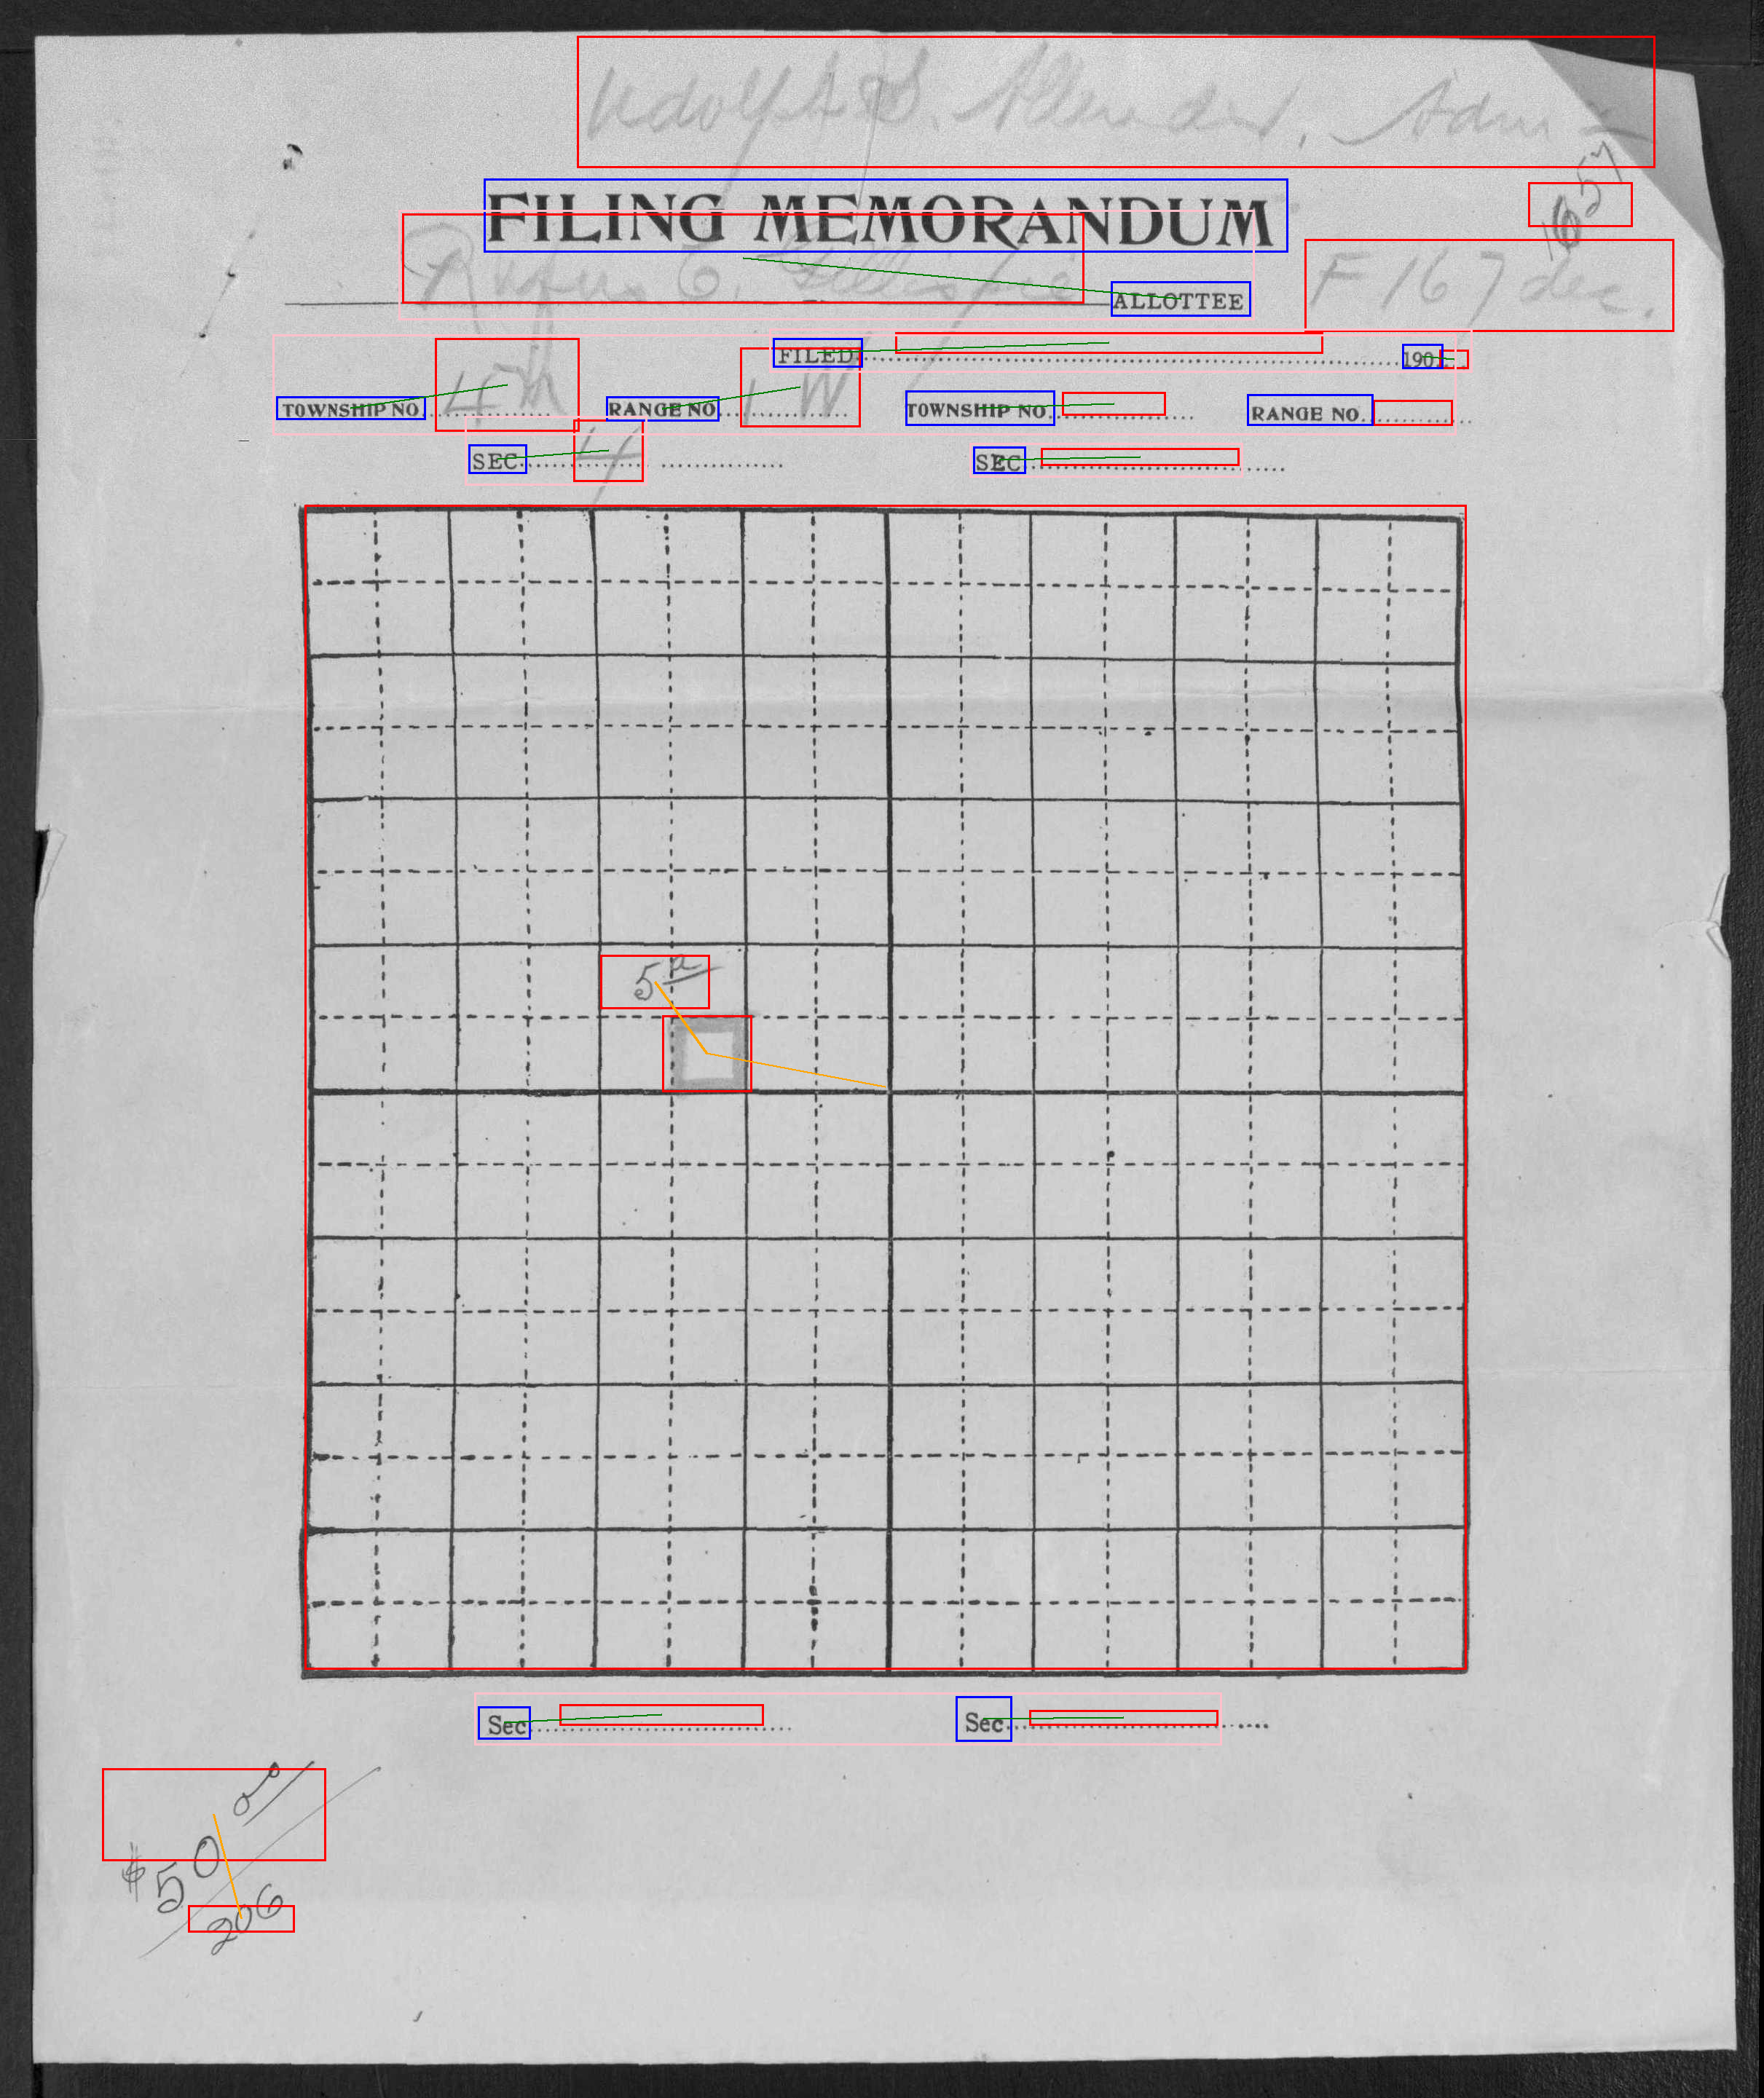

In [61]:
center = lambda rect: ((rect[2]+rect[0])/2, (rect[3]+rect[1])/2)
pairs = anns['pairs']
same_pairs = anns['samePairs']
horz_links = anns['horzLinks']

for pair in pairs: # KEY-VALUE PAIRS
    center_start = center(bboxs[pair[0]]['coords'])
    center_end = center(bboxs[pair[1]]['coords'])
    draw.line((center_start, center_end), fill='green', width=3)

for pair in same_pairs: # GROUP ENTITIES
    center_start = center(bboxs[pair[0]]['coords'])
    center_end = center(bboxs[pair[1]]['coords'])
    draw.line((center_start, center_end), fill='orange', width=3)

for vector in horz_links: # LINES
    line = [box['coords'] for tag, box in bboxs.items() if tag in vector]
    min_x1 = min([point[0] for point in line]) - 5
    min_y1 = min([point[1] for point in line]) - 5
    max_x2 = max([point[2] for point in line]) + 5
    max_y2 = max([point[3] for point in line]) + 5
    draw.rectangle([min_x1, min_y1, max_x2, max_y2], outline='pink', width=3)

img

Using YoloBoxDetector
Run image through model: /home/gemelli/projects/doc2graph/DATA/NAF/groups/155/004173988_00022.jpg
Process bounding boxes: /home/gemelli/projects/doc2graph/DATA/NAF/groups/155/004173988_00022.jpg


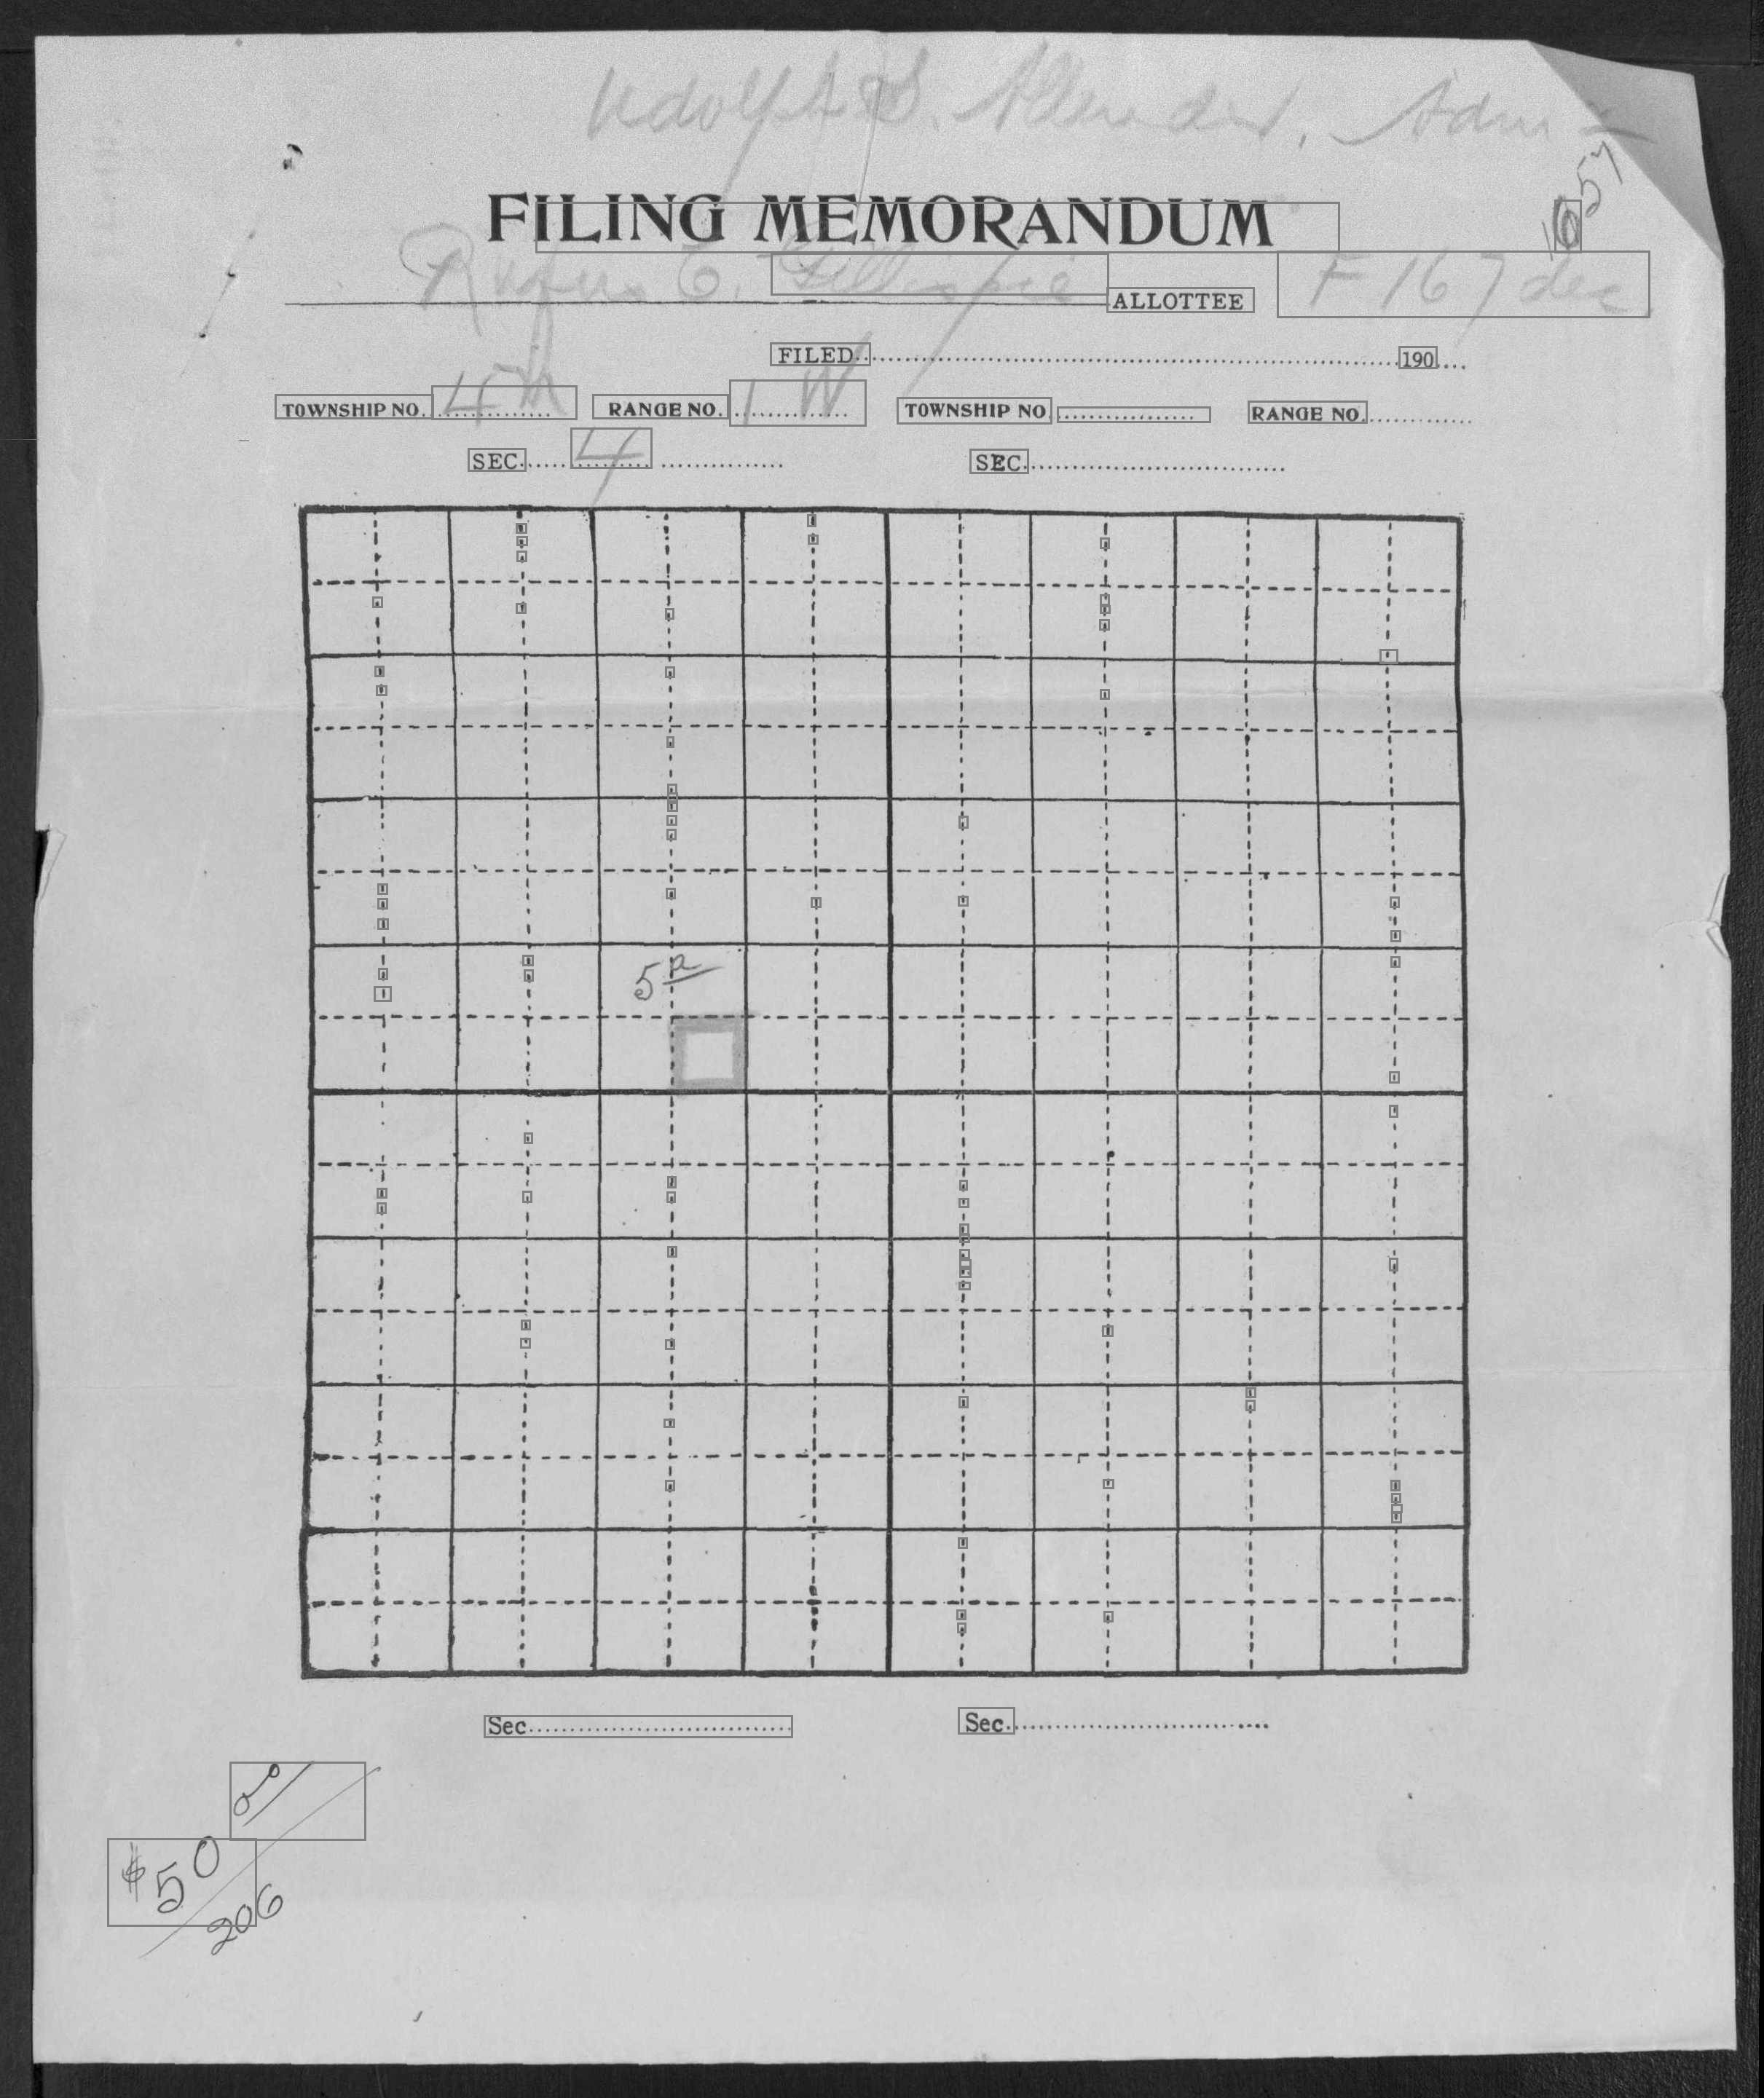

In [66]:
import sys
from src.paths import FUDGE, ROOT
sys.path.append(os.path.join(ROOT,'FUDGE'))
from FUDGE.run import detect_boxes
from src.data.amazing_utils import transform_image

model = FUDGE / 'saved/NAF_detect_augR_staggerLighter.pth'
img_input = transform_image(os.path.join(full_path))

boxes, visual_features = detect_boxes(
    img_input,
    img_path = full_path,
    output_path=ROOT,
    include_threshold= 0.8,
    model_checkpoint = model,
    device='cuda:0',
    debug=False)

img = Image.open(full_path).convert('RGB')
draw = ImageDraw.Draw(img)

for box in boxes:
    draw.rectangle(box.tolist(), outline='grey', width=3)

img